# Sparkify Project Workspace


Suppose, we are the data team of a popular digital music service similar to Spotify or Pandora. The users stream their favorite songs either using the free tier that place advertisements between songs or use the premium plan for which they pay a monthly fee without any advertisements between songs. Users can upgrade, downgrade or altogether cancel their services. The dataset given to us contains a log of the activities of each user on the service whether they are playing songs, logging out, upgrading their service or cancelling it. All this data contains key insights in keeping the users of the service happy. Our task in this project is to develop a model that predict which users are at risk. If we can identify users that are at risk to churn either by downgrading from premium or by cancelling their service, the business can offer them incentives and discounts potentially saving millions in revenues. 

To tackle this project, we are given a subset of the dataset that contains a log of events mentioned below. The events include:

1. Cancel
2. Submit Downgrade
3. Thumbs Down
4. Home
5. Downgrade
6. Roll Advert
7. Logout
8. Save Settings
9. Cancellation Conf...
10. About
11. Submit Registration
12. Settings
13. Login
14. Register
15. Add to Playlist
16. Add Friend
17. NextSong
18. Thumbs Up
19. Help
20. Upgrade

To solve this problem, first we load the dataset into Apache Spark and delete any rows that have missing userIds or sessionIds. Then we calculate the below mentioned metrics from the given data for each user.

1. average number of songs per session
2. Total number of thumbs down
3. Total number of thumbs up
4. Total number of errors encountered
5. Number of Add to Playlist events
6. Number of Add Friends events
7. Total number of songs played

The label which needs to be predicted is churn which is defined by a user who has performed either a "Submit Downgrade" event or "Cancellation Confirmation" event.

After the above features are calculated, we build the model using the following three algorithms:

1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting Trees

The dataset is split into training and testing sets. A machine learning pipeline is built in which we first convert each row into a single feature vector. Then data in each of the column is normalized and is fed into each of the above classifiers.

#### Metrics

The models are evaluated using the F1 score since we have a small number of churned users. F1 score is a better measure to use when there is an uneven class distribution. For our dataset, Gradient Boosted Tree Classifier gives the best F1 score. We also calculate the accuracy of each of the models but we base our decision of selecting a model based on the F1 score calculated.


In [18]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [19]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Spark - Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [20]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)


In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Statistics

##### Descriptive stats:


In [14]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


###### Skewness:

In [15]:
df.toPandas().skew(axis = 0, skipna = True)

itemInSession    2.480746
length           5.338281
registration    -1.586332
sessionId        0.217484
status           2.868533
ts               0.062416
dtype: float64

###### Kurtosis:

In [30]:
df.toPandas().kurt(axis = 0, skipna = True)

itemInSession     9.961081
length           85.489538
registration      3.205200
sessionId        -1.309083
status            6.573906
ts               -1.172516
dtype: float64

###### Histogram:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f722b59a5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f72432bd470>]], dtype=object)

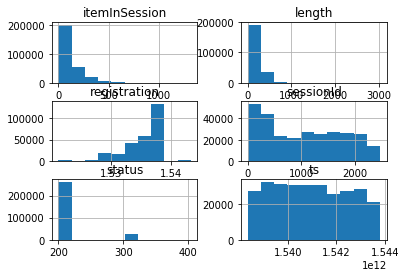

In [24]:
df.toPandas().hist()

In [7]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [8]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [9]:
df.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [10]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [11]:
df.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [12]:
session_ids = df.toPandas()['sessionId'].unique().tolist()
for id in session_ids:
    if id == '':
        print("Empty session ID")
    elif id is None:
        print("None session ID")

There are no empty session ids.

In [7]:
#Getting rid of rows that have missing userId and sessionId
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_valid = df_valid.filter(df_valid["userId"] != "")

#Converting to pandas dataframe for visualization
df_pandas = df_valid.toPandas()

In [9]:
# df_pandas.describe()

In [11]:
#Getting a list of churned users. A churned user is defined as someone who has executed "Submit Downgrade" or "Cancellation Confirmation"

churned_users = list(df_pandas[df_pandas['page'] == 'Submit Downgrade']['userId'].unique())
churned_users.extend(list(df_pandas[df_pandas['page'] == 'Cancellation Confirmation']['userId'].unique()))
churned_users = list(set(churned_users))


In [11]:
#Constructing dataframe to visualize churn with respect to gender
unique_userIds = df_pandas['userId'].unique().tolist()
gender = []
for userId in unique_userIds:
    gender.append(df_pandas[df_pandas['userId'] == userId]['gender'].iloc[0])
df_gender = pd.DataFrame({'userId': unique_userIds, 'gender': gender})
df_gender['churn'] = df_gender['userId'].apply(lambda x: 1 if x in churned_users else 0)


In [12]:
df_gender.head()


,userId,gender,churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0


In [13]:
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

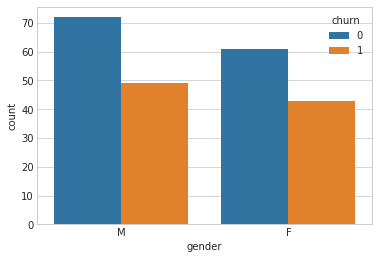

In [14]:
#churn with respect to gender. 1 means a user who has churned while 0 means a user who has not churned
sns.countplot(x = "gender", hue = "churn", data = df_gender)

In [15]:
#Constructing dataframe to visualize churn with respect to level
level = []
for userId in unique_userIds:
    level.append(df_pandas[df_pandas['userId'] == userId]['level'].iloc[0])
df_level = pd.DataFrame({'userId': unique_userIds, 'level': level})
df_level['churn'] = df_gender['userId'].apply(lambda x: 1 if x in churned_users else 0)
df_level.head()

,userId,level,churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0


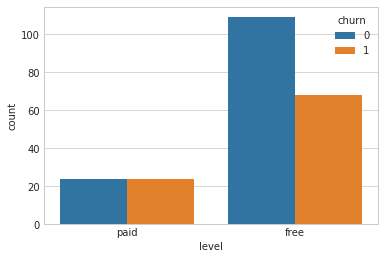

In [16]:
sns.countplot(x = "level", hue = "churn", data = df_level)

In [9]:
#Creating SQL view to manipulate the data

df_valid.createOrReplaceTempView("sparkify_table")

# Feature Engineering

For Feature Engineering, we combine two columns and group them by each event to get a count of respective features.

### Average Number of songs per session for each user

In [10]:
number_of_sessions = spark.sql("SELECT userId, avg(count) as average from (SELECT userId, count(*) as count FROM sparkify_table group by sessionId, userId) group by userId")

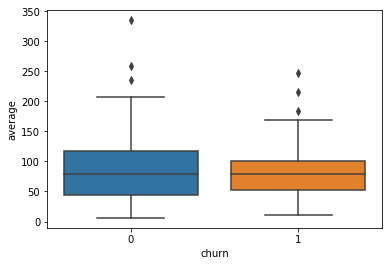

In [13]:
pd_num_sessions = number_of_sessions.toPandas()
pd_num_sessions['churn'] = pd_num_sessions['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="average", data=pd_num_sessions);

We can see that users who downgraded their service had a lesser number of songs on average per session.

### How many thumbs down for each user

In [11]:
thumbs_down = spark.sql("SELECT userId, count(*) as count_thumbs_down FROM sparkify_table where page = 'Thumbs Down' group by userId")


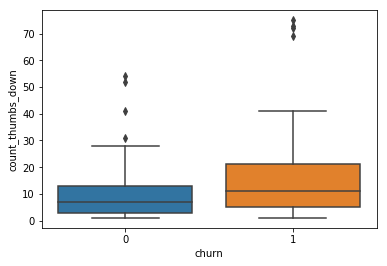

In [15]:
pd_thumbs_down = thumbs_down.toPandas()
pd_thumbs_down['churn'] = pd_thumbs_down['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_down", data=pd_thumbs_down)

Users who downgraded had more thumbs down than users who did not downgrade.

### How many thumbs up for each user

In [12]:
thumbs_up = spark.sql("SELECT userId, count(*) as count_thumbs_up FROM sparkify_table where page = 'Thumbs Up' group by userId")

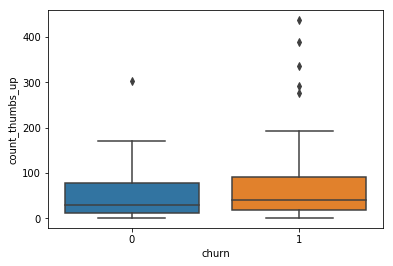

In [17]:
pd_thumbs_up = thumbs_up.toPandas()
pd_thumbs_up['churn'] = pd_thumbs_up['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_thumbs_up", data=pd_thumbs_up)

Surprisingly, users who downgraded also had more thumbs up.

### Total number of errors per user

In [13]:
errors = spark.sql("SELECT userId, count(*) as count_errors FROM sparkify_table where page = 'Error' group by userId")

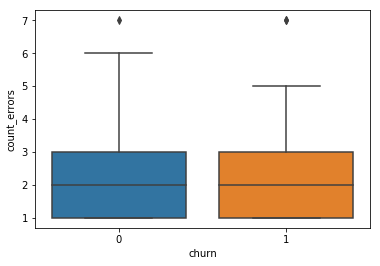

In [19]:
pd_errors = errors.toPandas()
pd_errors['churn'] = pd_errors['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_errors", data=pd_errors)

On average, both kinds of users had the same number of errors

### Number of Add to playlist events per user

In [14]:
add_to_playlist = spark.sql("SELECT userId, count(*) as count_add_to_playlist FROM sparkify_table where page = 'Add to Playlist' group by userId")

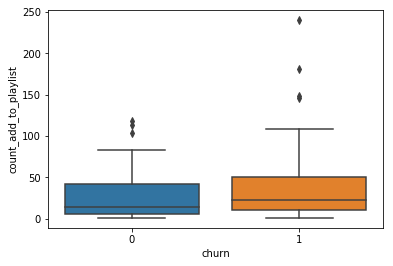

In [21]:
pd_add_to_playlist = add_to_playlist.toPandas()
pd_add_to_playlist['churn'] = pd_add_to_playlist['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_to_playlist", data=pd_add_to_playlist)

Both users have a same type of distribution for add to playlist events

### Number of add friends events per user

In [15]:
add_to_friends = spark.sql("SELECT userId, count(*) as count_add_friends FROM sparkify_table where page = 'Add Friend' group by userId")

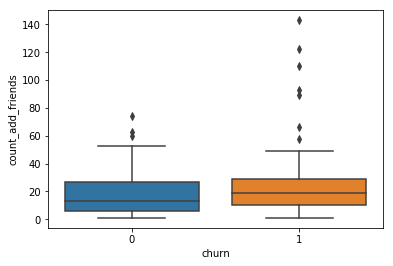

In [23]:
pd_add_to_friends = add_to_friends.toPandas()
pd_add_to_friends['churn'] = pd_add_to_friends['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_add_friends", data=pd_add_to_friends)

Users who churned on average added more friends 

### Total Songs played by each user

In [16]:
total_songs = spark.sql("SELECT userId, count(*) as count_total_songs FROM sparkify_table group by userId")

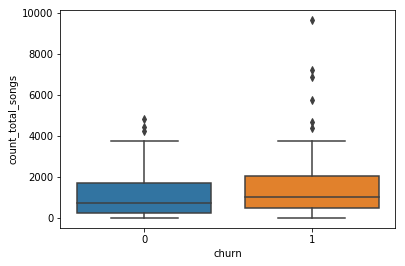

In [25]:
pd_total_songs = total_songs.toPandas()
pd_total_songs['churn'] = pd_total_songs['userId'].apply(lambda x: 1 if x in churned_users else 0)
sns.boxplot(x="churn", y="count_total_songs", data=pd_total_songs)

Churned users played more songs 

### Submit Downgrade or Cancellation Confirmation (Defining Churn)

In [17]:
# Churn is defined when a user performs "Submit Downgrade" or "Cancellation Confirmation"
flag_downgrade_event = udf(lambda x: 1 if (x == "Submit Downgrade" or x == 'Cancellation Confirmation') else 0, IntegerType())

In [18]:
a = spark.sql("SELECT userId, CASE when page = 'Submit Downgrade' or page = 'Cancellation Confirmation' THEN 1 END as churn from sparkify_table")

In [19]:
a.createOrReplaceTempView('churn_table')
b = spark.sql("SELECT * FROM churn_table where churn is not null")
b.createOrReplaceTempView('churn_users')

In [20]:
spark.sql("select * from churn_users").show()

+------+-----+
|userId|churn|
+------+-----+
|   131|    1|
|    38|    1|
|   141|    1|
|    18|    1|
|    30|    1|
|    20|    1|
|    32|    1|
|    12|    1|
|    11|    1|
|    61|    1|
|    81|    1|
|   125|    1|
|    85|    1|
|   140|    1|
|   105|    1|
|    17|    1|
|    35|    1|
|   143|    1|
|    54|    1|
|    77|    1|
+------+-----+
only showing top 20 rows



In [21]:
#Joining DataFrames to construct a unified dataset to be fed into machine learning model

temp1 = thumbs_down.join(thumbs_up, thumbs_down.userId == thumbs_up.userId).drop(thumbs_up.userId)
temp2 = temp1.join(errors, errors.userId == temp1.userId).drop(errors.userId)
temp3 = temp2.join(add_to_playlist, add_to_playlist.userId == temp2.userId).drop(add_to_playlist.userId)
temp4 = temp3.join(add_to_friends, add_to_friends.userId == temp3.userId).drop(add_to_friends.userId)
temp5 = temp4.join(total_songs, total_songs.userId == temp4.userId).drop(total_songs.userId)
temp6 = temp5.join(number_of_sessions, number_of_sessions.userId == temp5.userId).drop(number_of_sessions.userId)


In [22]:
temp7 = temp6.join(b, b.userId == temp6.userId, "left_outer").drop(b.userId)

In [23]:
temp7.createOrReplaceTempView('temp_table')
processed_df = spark.sql("select userId, count_thumbs_down, count_thumbs_up, count_errors, count_add_to_playlist, count_add_friends, count_total_songs, average, CASE when churn is null then 0 else 1 END as label from temp_table")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

We use the following 3 algorithms to build our model:

1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting Trees

The dataset is split into training and validation data in a ratio of 90% to 10%. Also we find the best hyperparameters for each of the models using grid search.

In [24]:
train, test = processed_df.randomSplit([0.9, 0.1], seed=42)

In [25]:
processed_df.columns

input_cols = ['count_thumbs_down',
 'count_thumbs_up',
 'count_errors',
 'count_add_to_playlist',
 'count_add_friends',
 'count_total_songs',
 'average']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

### Logistic Regression

In [29]:
lr =  LogisticRegression(labelCol="label", featuresCol="scaled_features", maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline_lr = Pipeline(stages=[assembler, scalar, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics
results_lr = cvModel_lr.transform(test)
print("Accuracy for Logistic Regression Model is: ", results_lr.filter(results_lr.label == results_lr.prediction).count()/ results_lr.count())
evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_lr)
print("F1 score for Logistic Regression model is : ", score)

Accuracy for Logistic Regression Model is:  0.6
F1 score for Logistic Regression model is :  0.638095238095238


For Logistic Regression, we performed grid search on regularization parameter with values of 0 and 0.1. 

In [49]:
print("The best performing regularization parameter is: ", cvModel_lr.bestModel.stages[-1]._java_obj.parent().getRegParam())

The best performing regularization parameter is:  0.1


### Random Forest Classifier

In [50]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", numTrees=10)
pipeline_rf = Pipeline(stages=[assembler, scalar, rf])


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[5, 10]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
results_rf = cvModel_rf.transform(test)
print("Accuracy for Random Forest Model is: ", results_rf.filter(results_rf.label == results_rf.prediction).count()/ results_rf.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_rf)
print("F1 score for Random Forest Model is: ", score)

Accuracy for Random Forest Model is:  0.8
F1 score for Random Forest Model is:  0.7999999999999999


For Random Forest Classifier, we perform grid search on number of Trees with values of 5 and 10.

In [52]:
print("The best value for number of trees is: ", cvModel_rf.bestModel.stages[-1]._java_obj.parent().getNumTrees())

The best value for number of trees is:  5


### Gradient Boosting Tree Classifier

In [27]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=10)
pipeline_gbt = Pipeline(stages=[assembler, scalar, gbt])
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5, 10]) \
    .build()
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3, collectSubModels=True)
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
results_gbt = cvModel_gbt.transform(test)
print("Accuracy for Gradient Boosting Tree Model is: ", results_gbt.filter(results_gbt.label == results_gbt.prediction).count()/ results_gbt.count())

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_gbt)
print("F1 score for Gradient Boosting Tree classifier is : ", score)

Accuracy for Gradient Boosting Tree Model is:  0.9
F1 score for Gradient Boosting Tree classifier is :  0.9066666666666667


For Gradient Boosting Tree Classifier, we perform grid search on maximum number of iterations with values of 5 and 10.

In [55]:
print("The best value for maximum number of iterations is: ", cvModel_gbt.bestModel.stages[-1]._java_obj.parent().getMaxIter())

The best value for maximum number of iterations is:  5


Gradient Boosting is the best performing model amongst the three models selected as the F1 score for GBT is the highest.

#### Validating the model with different fold scores

In [85]:
#Reference: https://stackoverflow.com/questions/38874546/spark-crossvalidatormodel-access-other-models-than-the-bestmodel/38874828#38874828

import numpy as np

from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.sql.functions import rand

class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()

        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                metric = eva.evaluate(model.transform(validation, paramMap))
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg so far: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))

In [86]:
model = CrossValidatorVerbose(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model.fit(train)

Comparing models on fold 1
params: {'maxIter': 5}	f1: 0.567568	avg: 0.567568
params: {'maxIter': 10}	f1: 0.594595	avg: 0.594595
Comparing models on fold 2
params: {'maxIter': 5}	f1: 0.675392	avg: 0.621480
params: {'maxIter': 10}	f1: 0.675392	avg: 0.634993
Comparing models on fold 3
params: {'maxIter': 5}	f1: 0.831339	avg: 0.691433
params: {'maxIter': 10}	f1: 0.806037	avg: 0.692008
Best model:
params: {'maxIter': 10}	f1: 0.692008


CrossValidatorModel_e81f2f71fb73

On the training data, we get an average F1 score of 0.692

#### Calculating Feature Importances


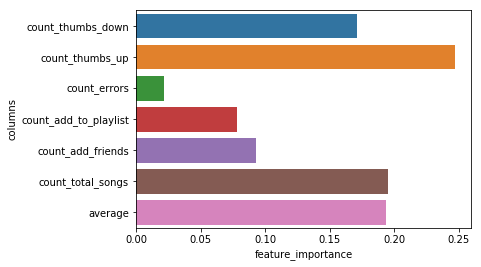

In [87]:
feature_importances = cvModel_gbt.bestModel.stages[2].featureImportances.values.tolist()
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'columns': input_cols})
sns.barplot(x='feature_importance', y='columns', data=feature_importance_df)

We can see that count of thumbs up is the most important feature in predicting user churn. Other important features include total songs played and the average length of the sessions for a user.

### Conclusion

To summarize our solution for the Sparkify Project, we execute the following steps:

1. Load the dataset into Apache Spark and clean it of any missing userIds and sessionsIds
2. Calculate features that help us model our solution
3. Feed the newly calculated features into 3 machine learning algorithms. Find the best hyperparameters and the model amongst these
4. Calculate the features that are most important in predicting user churn

One of the things I found difficult was deciding which features to calculate to build the model. I used my intuition to calculate features I felt would be useful in predicting churn.

### Discussion

As I mentioned earlier, one of the things that could have been improved was deciding which features to calculate. Other features that I could have used are:

1. Average length of each session for a user
2. Logout events

Implementing these features would make our model more robust and accurate. 